In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
sys.path.append('/home/leachl/Documents/Simple_models/FaIR_v2-0/FaIR_v2-0/')
from UnFaIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
from scipy.io.idl import readsav
import os
import netCDF4
from difflib import SequenceMatcher
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from datetime import datetime

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [2]:
gas_params_AR5 = get_gas_parameter_defaults()

thermal_params_AR5 = get_thermal_parameters().iloc[:,:2]

In [3]:
thermal_params_AR5.loc['d'] = [409.5,8.4]
thermal_params_AR5.loc['q'] = [0.429,0.631]

In [4]:
gas_params_AR5.loc['tau1',('default','CH4')] = 12.4
gas_params_AR5.loc['tau1',('default','N2O')] = 121

gas_params_AR5.loc['r0':'rT'] = 0

gas_params_AR5.loc['f1':'f3'] = 0

gas_params_AR5.loc['PI_conc'] = [391,1803,324]

tau = gas_params_AR5.loc['tau1':'tau4'].values.T
a = gas_params_AR5.loc['a1':'a4'].values.T

g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)

gas_params_AR5.loc['r0'] = g1*np.arcsinh(1/g0)

gas_params_AR5.loc['f2'] = [1000*1.37e-5 , 3.63e-4 , 3.00e-3]

gas_params_AR5_adjust = gas_params_AR5.copy()

gas_params_AR5_adjust.loc['f2'] = [1000*1.37e-5 , 1.65 * 3.63e-4 , ( 1 - 0.36*1.65*( 3.63e-4/3.00e-3 ) ) * 3.00e-3]

In [5]:
metric_run = return_empty_emissions(start_year=0,end_year=500,scen_names=['0','CO2','CH4','N2O'],timestep=0.1)

In [6]:
pulse_ems = {'CO2':(1/1000)*12/44.01,'CH4':1,'N2O':1*28/44}

for gas in ['CO2','CH4','N2O']:
    
    metric_run.loc[metric_run.index[0],(gas,gas)] = pulse_ems[gas]

In [7]:
metric_results = run_UnFaIR(emissions_in=metric_run,gas_parameters=gas_params_AR5,thermal_parameters=thermal_params_AR5)
metric_results_adjust = run_UnFaIR(emissions_in=metric_run,gas_parameters=gas_params_AR5_adjust,thermal_parameters=thermal_params_AR5)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.05 and 500.95000000000005...
Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.05 and 500.95000000000005...


[(0, 320), (0, 320)]

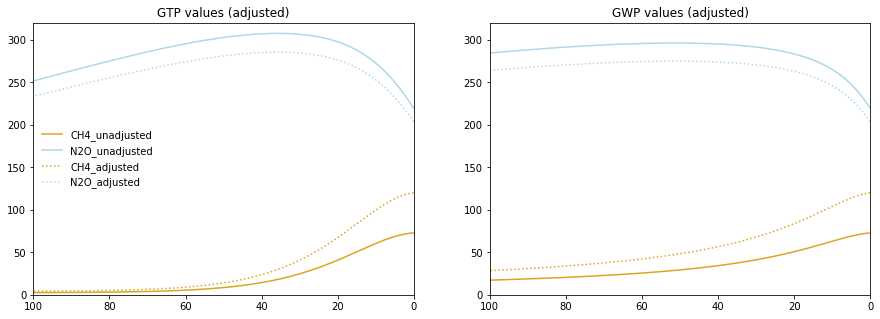

In [18]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

axes = ax.flatten()

axes[0].plot(metric_results['T']['CH4']/metric_results['T']['CO2'],c='goldenrod',label='CH4_unadjusted')
axes[0].plot(metric_results['T']['N2O']/metric_results['T']['CO2'],c='lightblue',label='N2O_unadjusted')
axes[0].set_title('GTP values (unadjusted)')

axes[1].plot(metric_results['RF'].cumsum()['CH4','default','default','CH4']/metric_results['RF'].cumsum()['CO2','default','default','CO2'],c='goldenrod',label='CH4')
axes[1].plot(metric_results['RF'].cumsum()['N2O','default','default','N2O']/metric_results['RF'].cumsum()['CO2','default','default','CO2'],c='lightblue',label='N2O')
axes[1].set_title('GWP values (unadjusted)')

axes[0].plot(metric_results_adjust['T']['CH4']/metric_results_adjust['T']['CO2'],c='goldenrod',label='CH4_adjusted',ls=':')
axes[0].plot(metric_results_adjust['T']['N2O']/metric_results_adjust['T']['CO2'],c='lightblue',label='N2O_adjusted',ls=':')
axes[0].set_title('GTP values (adjusted)')

axes[1].plot(metric_results_adjust['RF'].cumsum()['CH4','default','default','CH4']/metric_results_adjust['RF'].cumsum()['CO2','default','default','CO2'],c='goldenrod',label='CH4_adjusted',ls=':')
axes[1].plot(metric_results_adjust['RF'].cumsum()['N2O','default','default','N2O']/metric_results_adjust['RF'].cumsum()['CO2','default','default','CO2'],c='lightblue',label='N2O_adjusted',ls=':')
axes[1].set_title('GWP values (adjusted)')

axes[0].legend(loc='center left',frameon=False)

[x.set_xlim(100,0) for x in axes]

[x.set_ylim(0,320) for x in axes]

In [34]:
for timescale in [20,100]:
    for gas in ['CH4','N2O']:
        
        print(gas+' GWP'+str(timescale)+' direct+indirect:',round((metric_results_adjust['RF'].cumsum()[gas,'default','default',gas]/metric_results_adjust['RF'].cumsum()['CO2','default','default','CO2']).iloc[timescale*10],2))
        
        print(gas+' GWP'+str(timescale)+' direct:',round((metric_results['RF'].cumsum()[gas,'default','default',gas]/metric_results['RF'].cumsum()['CO2','default','default','CO2']).iloc[timescale*10],2))
        
        print(gas+' GTP'+str(timescale)+' direct+indirect:',round((metric_results_adjust['T'][gas]/metric_results_adjust['T']['CO2']).iloc[timescale*10].values[0],2))
        
        print(gas+' GTP'+str(timescale)+' direct:',round((metric_results['T'][gas]/metric_results['T']['CO2']).iloc[timescale*10].values[0],2))

CH4 GWP20 direct+indirect: 83.65
CH4 GWP20 direct: 50.7
CH4 GTP20 direct+indirect: 67.15
CH4 GTP20 direct: 40.7
N2O GWP20 direct+indirect: 263.24
N2O GWP20 direct: 283.63
N2O GTP20 direct+indirect: 276.49
N2O GTP20 direct: 297.9
CH4 GWP100 direct+indirect: 28.45
CH4 GWP100 direct: 17.24
CH4 GTP100 direct+indirect: 4.27
CH4 GTP100 direct: 2.59
N2O GWP100 direct+indirect: 264.19
N2O GWP100 direct: 284.65
N2O GTP100 direct+indirect: 233.62
N2O GTP100 direct: 251.71
